<a href="https://colab.research.google.com/github/naguzmans/opportunistic-utm/blob/master/06_PSO_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/opportunistic-utm/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Prediction

In [ ]:
import numpy as np
prediction_array = np.load('dataset/00_results/prediction_array.npy')
prediction_array.shape

(100, 100, 20)

# 2D Particle Swarm Optimization

100%|██████████| 50/50 [00:32<00:00,  1.53it/s]

Final Global Best Cost: 417.32662172314656


<Figure size 432x288 with 0 Axes>

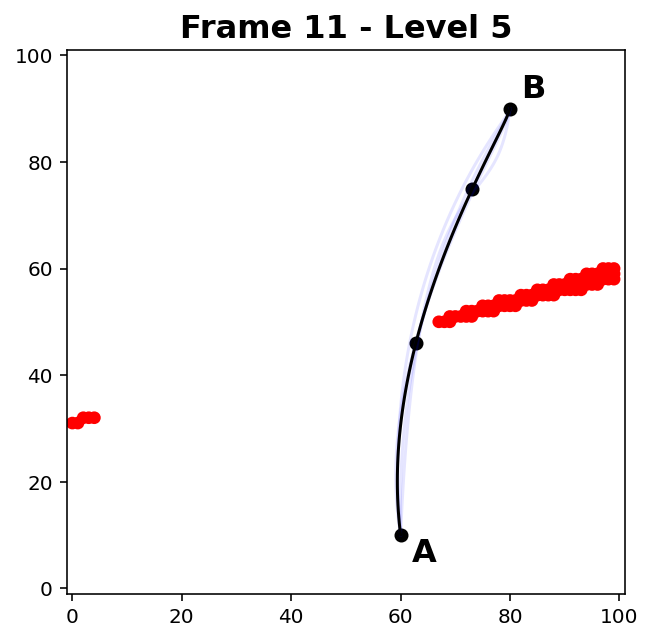

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

class Obstacle:
  def __init__(self, x, y, r):
    self.x = x
    self.y = y
    self.r = r

class Particle:
  def __init__(self, origin, destination, handles):
    self.origin = origin
    self.destination = destination

    # Define x array
    self.x, self.y = self.CreatePath(self.origin, self.destination, handles)

    # Define velocity
    self.vx = np.zeros(handles+2)
    self.vy = np.zeros(handles+2)

    # Calculate Cost
    self.Cost()
    
    # Define Best
    self.Best(self.x, self.y, self.xs, self.ys, self.cost)

  def Cost(self):

    # Create spline
    ts = np.linspace(self.origin[0], self.destination[0], handles+2 )
    spline_x = interpolate.CubicSpline(ts, self.x)
    spline_y = interpolate.CubicSpline(ts, self.y)

    ts2 = np.linspace(self.origin[0], self.destination[0], 100)
    self.xs = spline_x(ts2)
    self.ys = spline_y(ts2)

    dsx = spline_x.derivative(nu=1)
    dsy = spline_y.derivative(nu=1)
    self.dxs = dsx(ts2)
    self.dys = dsy(ts2)
    self.L = np.sum(np.sqrt(self.dxs**2 + self.dys**2))
    
    violation = 0
    for i in range(0, len(obstacles)):
      distance_to_obstacle = np.sqrt((self.xs-obstacles[i].x)**2+(self.ys-obstacles[i].y)**2)
      v = 1-distance_to_obstacle/obstacles[i].r
      for j in range(0,len(v)):
        if v[j] < 0:
          v[j] = 0
      violation += np.mean(v)

    # Calculate final cost
    beta = 1000
    # self.cost = np.sum(distance_to_obstacle)*(1+beta*violation)
    self.cost = self.L*(1+beta*violation)

  def Best(self, x, y, xs, ys, cost):
    self.best_x = x
    self.best_y = y
    self.best_xs = xs
    self.best_ys = ys
    self.best_cost = cost

  def CreatePath(self, start, end, handles):
    x = np.random.uniform(start[0], end[0], handles+2)
    # x = np.random.random_integers(start[0], end[0], handles+2)
    x[0] = start[0]
    x[-1] = end[0]

    y = np.random.uniform(start[1], end[1], handles+2)
    # y = np.random.random_integers(start[1], end[1], handles+2)
    y[0] = start[1]
    y[-1] = end[1]

    # x = x/x[-1] * end[0]
    # y = y/y[-1] * end[1]

    return x,y

class GlobalBest:
  def __init__(self, x, y, xs, ys, cost):
    self.x = x
    self.y = y
    self.xs = xs
    self.ys = ys
    self.cost = cost
    
# Create model obstacles
level = 5
frame = 11
prediction_array = np.load('dataset/00_results/prediction_array.npy')[frame][:,:,level]
flights_envelope = np.load('dataset/00_results/flights_envelope_2019.npy')[0][:,:,0]
prediction_array *= flights_envelope

obstacles = []
for j in range(100):
  for k in range(100):
    if prediction_array[j,k] == 1:
      obstacles.append(Obstacle(k,j,3))

# Create Particle Swarm
particles = []
number_of_particles = 100
handles = 2
for i in range(number_of_particles):
  particles.append(Particle((60,10), (80,90), handles))

# Initialize
global_best = GlobalBest(0,0,0,0,1e6)
for particle in particles:
  if particle.cost < global_best.cost:
    global_best.x = particle.x.copy()
    global_best.y = particle.y.copy()
    global_best.xs = particle.xs.copy()
    global_best.ys = particle.ys.copy()
    global_best.cost = particle.cost.copy()
    # print(f'Initial Global Best Cost: {global_best.cost}')

# Particle Swarm Optimization
canvas_max_x = 100
canvas_min_x = 0
canvas_max_y = 100
canvas_min_y = 0
iterations = 50
w = 2
wdamp = .98
c1 = 1.5
c2 = 1.5
alpha = .1
vel_max_x = alpha*(canvas_max_x - canvas_min_x)
vel_min_x = -vel_max_x
vel_max_y = alpha*(canvas_max_y - canvas_min_y)
vel_min_y = -vel_max_y

plt.figure()
fig, ax = plt.subplots(figsize=(5,5))

# ax.set_xlabel('Distance (Unit)')
# ax.set_ylabel('Distance (Unit)')
ax.set_title(f'Frame {frame} - Level {level}', fontweight='bold', fontsize=16)

ax.set_xlim(canvas_min_x-1,canvas_max_x+1)
ax.set_ylim(canvas_min_y-1,canvas_max_y+1)
ax.text(60 + 2, 10 - 5, 'A', fontsize=16, fontweight = 'bold')
ax.text(80 + 2, 90 + 2, 'B', fontsize=16, fontweight = 'bold')

for obstacle in obstacles:
  ax.add_patch(plt.Circle((obstacle.x, obstacle.y), 1, color='r'))

for i in tqdm(range(0, iterations)):
  
  for particle in particles:

    # X
    particle.vx = w*particle.vx + \
                  c1*np.random.rand(1, handles+2).reshape(handles+2)*(particle.best_x-particle.x) + \
                  c2*np.random.rand(1, handles+2).reshape(handles+2)*(global_best.x-particle.x)
    
    particle.vx = np.maximum(particle.vx.copy(), vel_min_x)
    particle.vx = np.minimum(particle.vx.copy(), vel_max_x)
 
    # particle.x += particle.vx
    particle.x = np.add(particle.x, particle.vx, out=particle.x, casting='unsafe')

    # Y
    particle.vy = w*particle.vy + \
                  c1*np.random.rand(1, handles+2).reshape(handles+2)*(particle.best_y-particle.y) + \
                  c2*np.random.rand(1, handles+2).reshape(handles+2)*(global_best.y-particle.y)
    
    particle.vy = np.maximum(particle.vy.copy(), vel_min_y)
    particle.vy = np.minimum(particle.vy.copy(), vel_max_y)

    # particle.y += particle.vy
    particle.y = np.add(particle.y, particle.vy, out=particle.y, casting='unsafe')

    # print(f'Iteration {i} - Particle VX: {particle.vx} - Particle VY: {particle.vy}')

    # Calculate cost
    particle.Cost()
    if particle.cost < particle.best_cost:
      particle.best_x = particle.x.copy()
      particle.best_y = particle.y.copy()
      particle.best_xs = particle.xs.copy()
      particle.best_ys = particle.ys.copy()
      particle.best_cost = particle.cost.copy()

      # print(f'Particle Best X: {particle.best_x}')

    if particle.cost < global_best.cost:
      global_best.x = particle.x.copy()
      global_best.y = particle.y.copy()
      global_best.xs = particle.xs.copy()
      global_best.ys = particle.ys.copy()
      global_best.cost = particle.cost.copy()

      ax.plot(global_best.xs, global_best.ys, color ='b', alpha=.1)
      # ax.scatter(global_best.x, global_best.y, c = 'b', alpha=.1)

      # print(f'Global Best Cost: {global_best.cost}')

  # print(f'Global Best X Iter: {global_best.x}')
  w = w * wdamp
  
ax.plot(global_best.xs, global_best.ys, color ='k')
ax.scatter(global_best.x, global_best.y, c = 'k')
print(f'Final Global Best Cost: {global_best.cost}')
